In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Encode grades
grade_map = {"A":5, "B":4, "C":3, "D":2, "E":1, "F":0}
df["Grade_Num"] = df["Grade"].map(grade_map)

X = df[["Attendance"]]
y = df["Grade"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    random_state=42,
    class_weight="balanced"
)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.64      0.94      0.76        31
           B       0.59      0.50      0.54        38
           C       0.50      0.42      0.46        33
           D       0.35      0.32      0.34        37
           E       0.43      0.31      0.36        29
           F       0.47      0.59      0.53        32

    accuracy                           0.51       200
   macro avg       0.50      0.51      0.50       200
weighted avg       0.50      0.51      0.50       200

[[29  2  0  0  0  0]
 [16 19  3  0  0  0]
 [ 0 11 14  7  1  0]
 [ 0  0  9 12  5 11]
 [ 0  0  2  8  9 10]
 [ 0  0  0  7  6 19]]


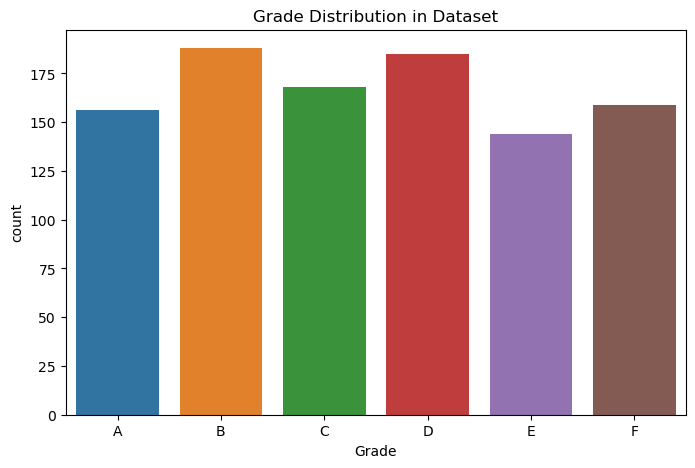

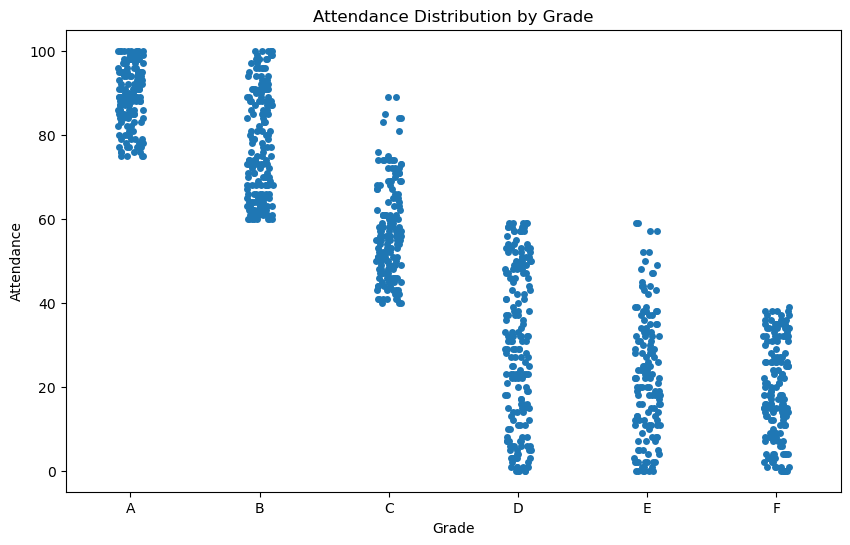

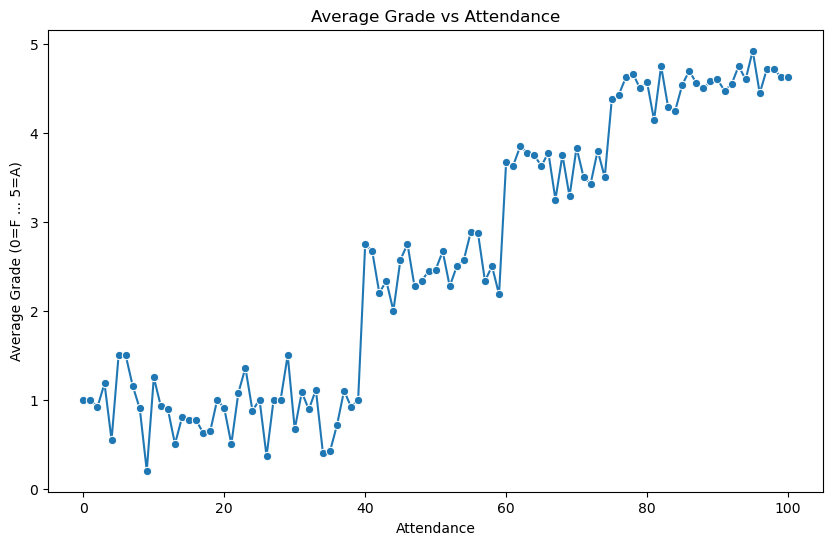

C:\Users\Oreoluwa\AppData\Local\Temp\ipykernel_10092\598784330.py:35: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(lambda x: x/x.sum())


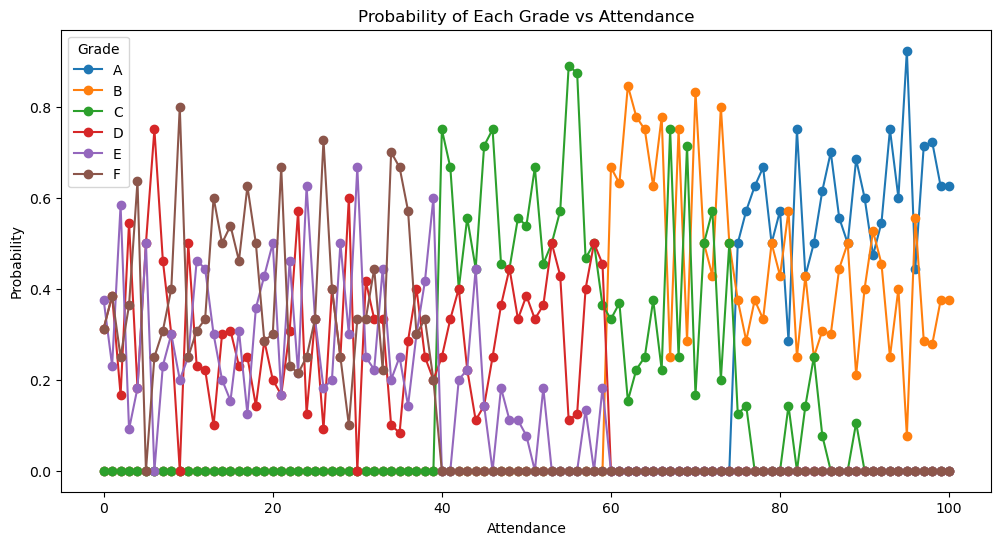

Correlation between Attendance and Grade: 0.87


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add predicted grade for full dataset
df["Predicted"] = model.predict(X)

# 1. Distribution of grades
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="Grade", order=["A","B","C","D","E","F"])
plt.title("Grade Distribution in Dataset")
plt.show()

# 2. Attendance vs Grade (scatter)
plt.figure(figsize=(10,6))
sns.stripplot(data=df, x="Grade", y="Attendance", order=["A","B","C","D","E","F"])
plt.title("Attendance Distribution by Grade")
plt.show()

# 3. Average grade vs attendance
df["Grade_Num"] = df["Grade"].map(grade_map)
attendance_trend = df.groupby("Attendance")["Grade_Num"].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=attendance_trend, x="Attendance", y="Grade_Num", marker="o")
plt.title("Average Grade vs Attendance")
plt.ylabel("Average Grade (0=F ... 5=A)")
plt.savefig('Average Grade vs Attendance.jpg')
plt.show()

# 4. Probability of each grade across attendance
grade_probs = (
    df.groupby(["Attendance","Grade"])
    .size()
    .groupby(level=0)
    .apply(lambda x: x/x.sum())
    .unstack(fill_value=0)
)

grade_probs.plot(figsize=(12,6), marker="o")
plt.title("Probability of Each Grade vs Attendance")
plt.ylabel("Probability")
plt.show()

# 5. Correlation
corr = df["Attendance"].corr(df["Grade_Num"])
print(f"Correlation between Attendance and Grade: {corr:.2f}")


In [5]:
#Create a new column for only students that passes (A,B,C)
df["Pass"] = df["Grade"].isin(["A","B","C"]).astype(int)  # 1 = Pass, 0 = Fail


In [6]:
from sklearn.linear_model import LogisticRegression

X = df[["Attendance"]]
y = df["Pass"]

log_reg = LogisticRegression()
log_reg.fit(X, y)

# Predict probabilities across all attendance values
attendance_range = np.arange(0, 101)
pass_probs = log_reg.predict_proba(attendance_range.reshape(-1,1))[:,1]


C:\Users\Oreoluwa\anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [14]:
#Set threshold for minimum percentage of passing
threshold = attendance_range[pass_probs >= 0.99][0]
print(f"📌 Minimum attendance required to have a 99% chance of passing: {threshold}%")


📌 Minimum attendance required to have a 99% chance of passing: 74%


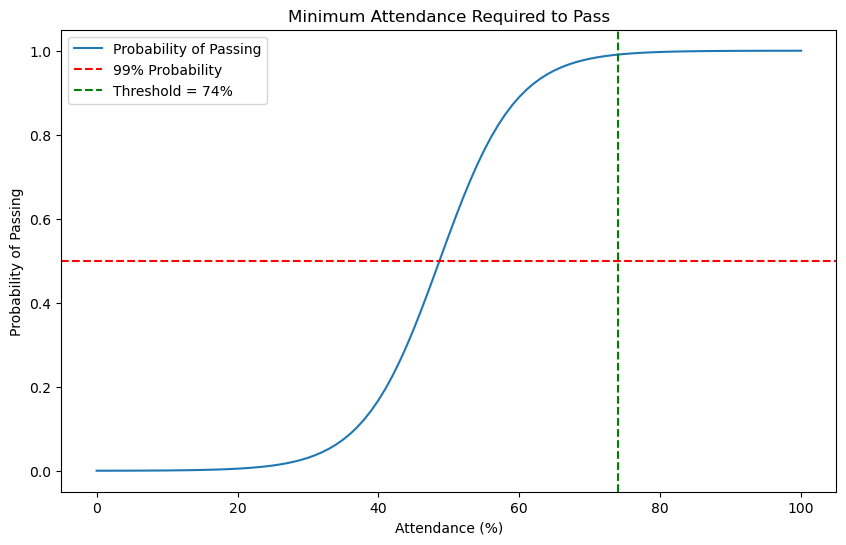

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(attendance_range, pass_probs, label="Probability of Passing")
plt.axhline(0.5, color="red", linestyle="--", label="99% Probability")
plt.axvline(threshold, color="green", linestyle="--", label=f"Threshold = {threshold}%")
plt.xlabel("Attendance (%)")
plt.ylabel("Probability of Passing")
plt.title("Minimum Attendance Required to Pass")
plt.legend()
plt.savefig('Minimum Attendance To Pass.jpg')
plt.show()
